<a href="https://colab.research.google.com/github/ROC5COR/stm32ai_datalogger_movementdetector/blob/main/STM32AI_DataLogger_MovementDetector_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Getting the data
We are getting the dataset directly from the GitHub, but you can use your own dataset instead.

The dataset has been generated using **GenericUI** application located here: https://github.com/STMicroelectronics/stm32ai-datalogger/tree/main/generic_ui

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/ROC5COR/stm32ai_datalogger_movementdetector/main/Capture-2020-09-01-10h07m03s.csv')
print("Data in file: {}".format(len(df)))

Data in file: 13175


# Preprocessing data
Here we are doing multiple steps:
- Data extraction
- Doing windowing of data + overlaping
- Scaling of data
- Shuffling data


In [15]:
# Extracting data from main dataset to different categories
leftright_df = df[df['label'] == 'leftright']
print("LeftRight data: {}".format(len(leftright_df)))

updown_df = df[df['label'] == 'updown']
print("UpDown data: {}".format(len(updown_df)))

idle_df = df[df['label'] == 'idle']
print("Idle data: {}".format(len(idle_df)))

# We can also trim data at the beginning and at the end to avoid transition between states
# Be sure also to have classes that are correctly weighted between each other

LeftRight data: 4100
UpDown data: 4114
Idle data: 4961


In [ ]:
# We want window of 100 data, this is what we are going to send to the neural network later
# We also want to do some overlapping of 1, which means that 1 new data will be added
# between two windows
window = 100
overlap_step = 1

# Because this is a simple dataset we are manually one-hotting our output data
y_encoding = {
    'leftright':[0,0,1],
    'updown':   [0,1,0],
    'idle':  [1,0,0]
}

X_dataset = []
Y_dataset = []

print("Windowing and overlaping...")
for i in np.arange(0, len(leftright_df) - window, overlap_step):
    data = leftright_df[['data1','data2','data3']][i:i+window]
    data = data.to_numpy()
    X_dataset.append(data)
    Y_dataset.append(y_encoding['leftright'])

for i in np.arange(0, len(updown_df) - window, overlap_step):
    data = updown_df[['data1','data2','data3']][i:i+window]
    data = data.to_numpy()
    X_dataset.append(data)
    Y_dataset.append(y_encoding['updown'])

for i in np.arange(0, len(idle_df) - window, overlap_step):
    data = idle_df[['data1','data2','data3']][i:i+window]
    data = data.to_numpy()
    X_dataset.append(data)
    Y_dataset.append(y_encoding['idle'])

# Numpyzing data because it is simpler
X_dataset = np.array(X_dataset)
Y_dataset = np.array(Y_dataset)

# Scaling data here, we simply divide by the max value that we have in our dataset
# this will give us values between -1 and 1
X_dataset /= 2000

print("X_dataset: {}, Y_dataset: {}".format(X_dataset.shape, Y_dataset.shape))

print("Shuffling datasets...")
shuffled_indices = np.arange(X_dataset.shape[0])
np.random.shuffle(shuffled_indices)
X_dataset = X_dataset[shuffled_indices]
Y_dataset = Y_dataset[shuffled_indices]

print("Done !")

# Designing an training neural network
- We split the dataset into sub dataset: one for training, one for validating (during training) and one for testing (at the end)
- We are using keras to build and training our neural network


In [10]:
train_valid_ratio = 0.75
valid_test_ratio = 0.85
X_train = X_dataset[:int(len(X_dataset)*train_valid_ratio)]
Y_train = Y_dataset[:int(len(Y_dataset)*train_valid_ratio)]
X_valid = X_dataset[int(len(X_dataset)*train_valid_ratio): int(len(X_dataset)*valid_test_ratio)]
Y_valid = Y_dataset[int(len(Y_dataset)*train_valid_ratio): int(len(Y_dataset)*valid_test_ratio)]
X_test = X_dataset[int(len(X_dataset)*valid_test_ratio):]
Y_test = Y_dataset[int(len(Y_dataset)*valid_test_ratio):]

print("X_train: {}, Y_train: {}, X_valid: {}, Y_valid: {}, X_test: {}, Y_test: {}"
	.format(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape))


X_train: (9656, 100, 3), Y_train: (9656, 3), X_valid: (1287, 100, 3), Y_valid: (1287, 3), X_test: (1932, 100, 3), Y_test: (1932, 3)


In [17]:
print("Creating Conv1D model...")
from tensorflow import keras as k
model = k.Sequential([
    k.layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(window, 3)), # 3: Xacc,Yacc,Zacc
    k.layers.Conv1D(filters=8, kernel_size=3, activation='relu'),
    k.layers.Dropout(0.5),
    # k.layers.MaxPooling1D(pool_size=2),
    k.layers.Flatten(),
    k.layers.Dense(50, activation='relu'),
    k.layers.Dense(3, activation='softmax')
])


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=10, shuffle=True)
model.save('leftright_updown_convolutionnal.h5')

Creating Conv1D model...
Epoch 1/10
302/302 [==============================] - 2s 6ms/step - loss: 0.1646 - accuracy: 0.9351 - val_loss: 0.0104 - val_accuracy: 0.9977
Epoch 2/10
302/302 [==============================] - 2s 6ms/step - loss: 0.0087 - accuracy: 0.9987 - val_loss: 0.0074 - val_accuracy: 0.9992
Epoch 3/10
302/302 [==============================] - 2s 5ms/step - loss: 0.0054 - accuracy: 0.9992 - val_loss: 0.0044 - val_accuracy: 0.9992
Epoch 4/10
302/302 [==============================] - 2s 5ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.0034 - val_accuracy: 0.9992
Epoch 5/10
302/302 [==============================] - 2s 5ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.0025 - val_accuracy: 0.9992
Epoch 6/10
302/302 [==============================] - 2s 6ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0019 - val_accuracy: 0.9992
Epoch 7/10
302/302 [==============================] - 2s 5ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0024 - va

Model evaluation: [0.0027099926955997944, 0.998964786529541]


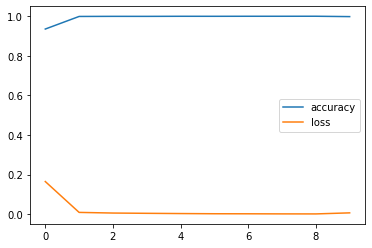

In [22]:
accuracy_plt = plt.plot(history.history['accuracy'], label='accuracy')
loss_plt = plt.plot(history.history['loss'], label='loss')
plt.legend()

# Evaluating on test data to check final accuracy
evaluation = model.evaluate(X_test, Y_test, verbose=0)
print("Model evaluation: {}".format(evaluation))